### Demonstrativos financeiros

Uma companhia de capital aberto deve apurar as seguintes demonstrações em atendimento às exigências da Comissão de Valores Mobiliários (CVM), B3 e seus acionistas:

*Demonstrações Financeiras Padronizadas* (DFP) – Este documento é composto por todos os demonstrativos financeiros referentes ao exercício social encerrado, e deve ser encaminhado ao final de cada trimestre de cada ano à CVM e à B3. https://dados.cvm.gov.br/dataset/cia_aberta-doc-dfp 
Deve ser entregue pelo emissor nacional em até 3 (três) meses contados do encerramento do exercício social ou na mesma data de envio das demonstrações financeiras, o que ocorrer primeiro.

*Informações e Resultados Trimestrais* (ITR) – São elaborados e enviados por todas as companhias listadas em Bolsa de Valores para a CVM e B3 todo trimestre. A ITR tem por finalidade permitir que o investidor acompanhe o desempenho da empresa no trimestre. https://dados.cvm.gov.br/dataset/cia_aberta-doc-itr
Deve ser entregue pelo emissor no prazo de 45 (quarenta e cinco) dias contados da data de encerramento
de cada trimestre.

Relatórios contábeis elaborados periodicamente pelas empresas. 
- Balanço Patrimonial Ativo (BPA)
- Balanço Patrimonial Passivo (BPP)
- Demonstração de Fluxo de Caixa - Método Direto (DFC-MD)
- Demonstração de Fluxo de Caixa - Método Indireto (DFC-MI)
- Demonstração das Mutações do Patrimônio Líquido (DMPL)
- Demonstração de Resultado Abrangente (DRA)
- Demonstração de Resultado (DRE)
- Demonstração de Valor Adicionado (DVA)

Os arquivos contêm duas versões: consolidadas (con) e indivuduais (ind):

'itr_cia_aberta_DRE_ind_2023.csv' - apenas a própria empresa, desconsiderando suas subsidiadas

'itr_cia_aberta_DRE_con_2023.csv' - contemplam todas as empresas do grupo que a empresa possui participação, e.g. no caso de uma holding 

Os demonstrativos consolidados são os mais usados pelo mercado. 

In [56]:
ano_inicio  = 2014
ano_fim     = 2024 # Evite colocar ano onde não há dados ainda

In [57]:
import os
import pandas as pd
import urllib.request
from zipfile import ZipFile
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


In [58]:
# get_cvm_file(  2024 , 2024)# , path='/home/yair/teste' )

In [59]:
def get_cvm_file(start_year=2010, end_year=2025, report='dfp', path=None, dl=False) -> str:
    '''
    Baixa arquivos zipados com demonstrativos financeiros do site da CVM
    
    Args:
        start_year (int): ano inicial
        end_year (int): ano final
        report (str): tipo de relatório - 'DFP' (anual) ou 'ITR' (trimestral)
        path (str): diretório para salvar os arquivos (padrão: './data/cvm_zipped')
        dl (bool): se True, força download (sobrescreve arquivos existentes);
                   se False, baixa apenas se o arquivo não existir localmente
    
    Returns:
        str: caminho do diretório contendo os arquivos zipados
    '''

    import os
    import pandas as pd
    import urllib.request

    # Define diretório de destino
    if path is None:
        path_data = os.path.join(os.getcwd(), 'data')
        os.makedirs(path_data, exist_ok=True)
        path_zipped = os.path.join(path_data, 'cvm_zipped')
        os.makedirs(path_zipped, exist_ok=True)
    else:
        os.makedirs(path, exist_ok=True)
        path_zipped = path
    
    url_cvm = f'https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/{report.upper()}/DADOS/'
    
    if dl:  # Força download incondicional
        for ano in range(start_year, end_year + 1):
            zipped_filename = f'{report}_cia_aberta_{ano}.zip'
            url = url_cvm + zipped_filename
            path_local_file = os.path.join(path_zipped, zipped_filename)
            
            try:
                print(f"Baixando {zipped_filename}...")
                urllib.request.urlretrieve(url, path_local_file)
                print(f"✓ Download concluído")
            except Exception as e:
                print(f"✗ Erro ao baixar {zipped_filename}: {e}")
    
    else:  # Baixa apenas se não existir localmente
        for ano in range(start_year, end_year + 1):
            zipped_filename = f'{report}_cia_aberta_{ano}.zip'
            url = url_cvm + zipped_filename
            path_local_file = os.path.join(path_zipped, zipped_filename)
            
            try:
                if not os.path.exists(path_local_file):
                    print(f"Baixando {zipped_filename}...")
                    urllib.request.urlretrieve(url, path_local_file)
                    print(f"✓ Download concluído")
                else:
                    print(f"✓ {zipped_filename} já existe localmente")
            except Exception as e:
                print(f"✗ Erro ao processar ano {ano}: {e}")
    
    return path_zipped

In [60]:
# extract_report( 2024 , 2024 , 'DRE_con' ).head(2)#, zip_dir='/home/yair/' ).head(3)

In [61]:
def extract_report(start_year, end_year, report='DRE_con', annual=True, zip_dir=None, rmzip = False) -> pd.DataFrame:
    '''
    Extrai dados específicos dos arquivos ZIP da CVM em um DataFrame
    
    Args:
        start_year (int): ano inicial
        end_year (int): ano final
        report (str): relatório a extrair. Opções disponíveis:
            BPA_con, BPA_ind, BPP_con, BPP_ind, DFC_MD_con, DFC_MD_ind,
            DFC_MI_con, DFC_MI_ind, DMPL_con, DMPL_ind, DRA_con, DRA_ind,
            DRE_con, DRE_ind, DVA_con, DVA_ind
        annual (bool): se True, usa DFP (anual); se False, usa ITR (trimestral)
        zip_dir (str): diretório contendo/para baixar os arquivos ZIP. 
                       Se None, usa './data/cvm_zipped'
                       Se especificado mas não existe, cria e baixa os arquivos nele
    
    Returns:
        pd.DataFrame: dados consolidados de todos os anos
    
    Raises:
        FileNotFoundError: se arquivos ZIP não forem encontrados após tentativa de download
    '''
    import pandas as pd
    from zipfile import ZipFile
    import os
    
    # Define tipo de relatório
    repP = 'dfp' if annual else 'itr'
    
    # Define diretório dos arquivos ZIP
    if zip_dir is not None:
        path_zipped = zip_dir
        # Se o diretório especificado não existe, cria e baixa os arquivos
        if not os.path.exists(path_zipped):
            print(f"Diretório {path_zipped} não encontrado. Criando e baixando arquivos...")
            path_zipped = get_cvm_file(start_year=start_year, end_year=end_year, 
                                      report=repP, path=zip_dir, dl=False)
            rmzip = True
    else:
        # Tenta usar diretório padrão
        path_zipped = os.path.join(os.getcwd(), 'data', 'cvm_zipped')
        if not os.path.exists(path_zipped):
            print(f"Diretório {path_zipped} não encontrado. Baixando arquivos...")
            path_zipped = get_cvm_file(start_year=start_year, end_year=end_year, 
                                      report=repP, dl=False)
    
    demonstrativo = pd.DataFrame()
    arquivos_processados = 0
    
    for ano in range(start_year, end_year + 1):
        zipped_file = f'{repP}_cia_aberta_{ano}.zip'
        full_path_file = os.path.join(path_zipped, zipped_file)
        
        # Verifica se o arquivo ZIP existe
        if not os.path.exists(full_path_file):
            print(f"⚠ Arquivo {zipped_file} não encontrado em {path_zipped}")
            try:
                # Tenta baixar apenas este arquivo específico
                get_cvm_file(start_year=ano, end_year=ano, 
                           report=repP, path=path_zipped, dl=True)
            except Exception as e:
                print(f"✗ Erro ao baixar {zipped_file}: {e}")
                continue
        
        try:
            # Abre o arquivo ZIP
            with ZipFile(full_path_file, 'r') as zip_ref:
                arquivos_no_zip = zip_ref.namelist()
                
                # Procura o CSV correspondente ao relatório
                arquivo_csv = None
                for arquivo in arquivos_no_zip:
                    if report.lower() in arquivo.lower() and arquivo.endswith('.csv'):
                        arquivo_csv = arquivo
                        break
                
                if arquivo_csv:
                    # Lê CSV diretamente do ZIP
                    with zip_ref.open(arquivo_csv) as csv_file:
                        df_ano = pd.read_csv(
                            csv_file, 
                            sep=';', 
                            decimal=',', 
                            encoding='latin1',
                            dtype={"ORDEM_EXERC": "category"}
                        )
                        demonstrativo = pd.concat([demonstrativo, df_ano], ignore_index=True)
                        arquivos_processados += 1
                        print(f"✓ Processado: {zipped_file} ({len(df_ano)} registros)")
                else:
                    print(f"⚠ CSV '{report}' não encontrado em {zipped_file}")
        
        except Exception as e:
            print(f"✗ Erro ao processar {zipped_file}: {e}")
            continue
    
    print(f"\n✓ Total de arquivos processados: {arquivos_processados}")    
    # if rmzip and os.path.exists(path_zipped):
    #     import shutil 
    #     shutil.rmtree(path_zipped)
    #     print(f"Diretório {path_zipped} removido!")
        
    
    return demonstrativo

In [62]:
def show_table(data, conta=[]):
  
    ''' Mostra uma dre_empresa organizada 

    Args:
        data (DataFrame): DataFrame do demonstrativo
        conta (list): Lista dos códigos das contas que se deseja filtrar

    Returns:
        DataFrame
'''

    # filtra as contas e as colunas de interesse
    data = data[data.CD_CONTA.isin(conta)][['DT_REFER','CD_CONTA','DS_CONTA','VL_CONTA']].drop_duplicates()
    data['DT_REFER'] = pd.to_datetime(data['DT_REFER'])
    data['Ano'] = data['DT_REFER'].dt.year.astype(str)
    data.reset_index(inplace = True, drop = True)

    data_pivot = data.pivot(index = ['CD_CONTA','DS_CONTA'], columns = 'Ano', values = 'VL_CONTA')

    year_cols = list(map(str,list(range(ano_inicio,ano_fim+1))))
    pct_changes = round(data_pivot[year_cols].pct_change(axis=1).iloc[:,1:] * 100, ndigits = 2)
    pct_changes.columns = [f'{start}-{end} Δ%' for start, end in zip(year_cols[:-1], year_cols[1:])]

    colunas_intercaladas = [col for pair in zip(data_pivot.columns, pct_changes.columns) for col in pair]
    colunas_intercaladas.append(data_pivot.columns[-1])

    return pd.concat([data_pivot, pct_changes], axis=1)[colunas_intercaladas]
#   return data_pivot


# DRE

In [63]:

## preparação dos dados

dre = extract_report( start_year = ano_inicio, end_year = ano_fim , report = 'DRE_con').copy()
# print(dre.info(memory_usage='deep')) # memory usage: 277.4 MB
## floats
dre['VL_CONTA'] = dre['VL_CONTA'].astype(float)
print(f"{dre['VL_CONTA'].isna().sum()} erros de conversão de numeros")
## strings
dre[['DENOM_CIA','CNPJ_CIA','CD_CONTA']] = dre[['DENOM_CIA','CNPJ_CIA','CD_CONTA']].astype('string')
## categories -- é um tipo especial do Pandas para dados categóricos (valores repetidos de um conjunto limitado). 1. Economia de memória (principal vantagem) 2. Performance em operações 3. Ordem definida customizavel
dre[['ESCALA_MOEDA','DS_CONTA','GRUPO_DFP','MOEDA','ST_CONTA_FIXA']] = dre[['ESCALA_MOEDA','DS_CONTA','GRUPO_DFP','MOEDA','ST_CONTA_FIXA']].astype('category')

dre['DT_REFER'] = pd.to_datetime(dre['DT_REFER'])
dre['DT_INI_EXERC'] = pd.to_datetime(dre['DT_INI_EXERC'])
dre['DT_FIM_EXERC'] = pd.to_datetime(dre['DT_FIM_EXERC'])
# print(dre.info(memory_usage='deep'))  # memory usage: 85.9 MB

# Normalização de Escala 
print('Escalas da moeda: ',dre.ESCALA_MOEDA.unique().tolist(),end=' --- ')
if len(dre.ESCALA_MOEDA.unique().tolist()) > 2: print('REVERIFICAR ESCALAS DE MOEDA!!!') 
else: print('Escalas OK')
dre['VL_CONTA'] = dre.apply(lambda row: row['VL_CONTA'] * 1000 if row['ESCALA_MOEDA'] == 'MIL' else row['VL_CONTA'], axis=1)
dre.head(1)

✓ Processado: dfp_cia_aberta_2014.zip (25121 registros)
✓ Processado: dfp_cia_aberta_2015.zip (24933 registros)
✓ Processado: dfp_cia_aberta_2016.zip (25006 registros)
✓ Processado: dfp_cia_aberta_2017.zip (24904 registros)
✓ Processado: dfp_cia_aberta_2018.zip (24682 registros)
✓ Processado: dfp_cia_aberta_2019.zip (27429 registros)
✓ Processado: dfp_cia_aberta_2020.zip (31296 registros)
✓ Processado: dfp_cia_aberta_2021.zip (32644 registros)
✓ Processado: dfp_cia_aberta_2022.zip (33784 registros)
✓ Processado: dfp_cia_aberta_2023.zip (33970 registros)
✓ Processado: dfp_cia_aberta_2024.zip (32036 registros)

✓ Total de arquivos processados: 11
0 erros de conversão de numeros
Escalas da moeda:  ['MIL', 'UNIDADE'] --- Escalas OK


,CNPJ_CIA,DT_REFER,VERSAO,DENOM_CIA,CD_CVM,GRUPO_DFP,MOEDA,ESCALA_MOEDA,ORDEM_EXERC,DT_INI_EXERC,DT_FIM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA,ST_CONTA_FIXA
0,00.000.000/0001-91,2014-12-31,2,BCO BRASIL S.A.,1023,DF Consolidado - Demonstração do Resultado,REAL,MIL,PENÚLTIMO,2013-01-01,2013-12-31,3.01,Receitas da Intermediação Financeira,1.045822e+11,S


In [64]:
print('DÊ PALAVRA-CHAVE PARA O NOME DE UMA EMPRESA: ',end='')
empresa = input('nome da empresa; palavra-chave: ')
print(empresa)

busca = empresa.upper().strip()
while True: 
    resultado = dre[dre['DENOM_CIA'].str.contains(busca)][['DENOM_CIA', 'CD_CVM']]
    if resultado.empty:
        print(f"Nenhum resultado encontrado para '{busca}'. Tente novamente com outra palavra-chave.")
        busca = input("Digite uma palavra-chave para buscar na coluna 'DENOM_CIA': ").strip().upper()
    else:
        print(resultado.drop_duplicates())
        break  # Sai do loop

DÊ PALAVRA-CHAVE PARA O NOME DE UMA EMPRESA: vale
       DENOM_CIA  CD_CVM
15983  VALE S.A.    4170


In [65]:
if len(resultado.drop_duplicates()[['CD_CVM']].values) == 1:  # se só encontrou uma empresa
    cod_cvm = resultado.drop_duplicates().iloc[0]['CD_CVM']
else:  
    print('DIGITE O CODIGO DESEJADO') 
    cod_cvm= int(input(f"Digite o código CVM dentre {list(resultado['CD_CVM'].drop_duplicates().values)}: "))

empresa = dre[dre['CD_CVM']==cod_cvm]['DENOM_CIA'].drop_duplicates().values[0]
empresa

'VALE S.A.'

# Filtros

Filtros deixar só informações necessárias:
 - ORDEM_EXERC linhas  com 'PENÚLTIMO' e 'ÚTIMO'. Usar o segundo, o outro é do ano anterior.
 - DT_FIM_EXERC no caso do ITR é  última data  do trimestre referente ao dado. Nos arquivos DFP há apenas o  mês 12.
 - DT_INI_EXERC. Quando mão aparece no demonstrativo, o valor mostrado representa a posição no final do semestre. Quando esse campo aparece, o valor corresponde ao total do período entre a data inicial (DT_INI_EXERC) e a data final (DT_FIM_EXERC). Pode aparecer em mais de uma linha, indicando períodos diferentes:

| Empresa | Conta   | DT_INI_EXERC | DT_FIM_EXERC | Valor |
| ------- | ------- | ------------ | ------------ | ----- |
| A       | Receita | 01/01/2023   | 30/06/2023   | 500   |
| A       | Receita | 01/04/2023   | 30/06/2023   | 300   |


ST_CONTA_FIXA refere-se ao Status da Conta Fixa, para entender a estrutura do plano de contas que a empresa utilizou para reportar seus resultados.

S (Sim): Indica que aquela é uma conta fixa (padronizada). São as linhas que a CVM define como obrigatórias ou padrão para todas as empresas de um determinado setor.

N (Não): Indica que aquela é uma conta não fixa (detalhada). São linhas adicionadas pela própria empresa para detalhar melhor suas operações. Por exemplo, dentro de "Outras Despesas Operacionais", uma empresa pode criar uma linha específica (Não Fixa) para descrever um custo peculiar ao seu negócio.ST_CONTA_FIXA refere-se ao Status da Conta Fixa.

Muitas vezes, o valor de uma conta fixa ("S") é o somatório de várias contas detalhadas ("N") logo abaixo dela. Ao manipular esses dados a regra de ouro é: Se quer um resumo padronizado, filtre por ST_CONTA_FIXA == 'S'. Se quer o detalhamento máximo e as notas explicativas digitais, analise as linhas com 'N', mas tome cuidado para não somá-las ao total da conta pai.

In [ ]:
remover_cols = ['GRUPO_DFP','MOEDA','ORDEM_EXERC','DENOM_CIA','CD_CVM','ESCALA_MOEDA'] 
dre_empresa = dre[(dre['CD_CVM']==cod_cvm) & (dre['ORDEM_EXERC']=='ÚLTIMO')].copy().drop(remover_cols, axis=1)
dre_empresa['ano'] = dre_empresa['DT_REFER'].dt.year
# As empresas frequentemente reapresentam seus demonstrativos à CVM (Versão 1, Versão 2, etc.) para corrigir erros.
dre_empresa = dre_empresa.sort_values('VERSAO').drop_duplicates(subset=['DT_REFER', 'CD_CONTA'], keep='last')
dre_empresa.head(2)

,CNPJ_CIA,DT_REFER,VERSAO,DT_INI_EXERC,DT_FIM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA,ST_CONTA_FIXA,ano
15984,33.592.510/0001-54,2014-12-31,1,2014-01-01,2014-12-31,3.01,Receita de Venda de Bens e/ou Serviços,8.827456e+10,S,2014
271006,33.592.510/0001-54,2023-12-31,1,2023-01-01,2023-12-31,3.06.02,Despesas Financeiras,-1.187700e+10,S,2023


Contas

In [124]:
from IPython.display import display, HTML

padrao = r"^\d+\.\d{2}$"
padrao2 = r"^\d+\.\d{2}\.\d{2}$"
padrao3 = r"^\d+\.\d{2}\.\d{2}\.\d{2}$"

# conta = dre_empresa[['CD_CONTA', 'DS_CONTA' , 'VL_CONTA']]
conta = dre_empresa[#(dre_empresa['VL_CONTA']!=0) & 
    (dre_empresa['CD_CONTA'].str.match(padrao))][['CD_CONTA', 'DS_CONTA' , 'VL_CONTA','ano']]
conta2 = dre_empresa[#(dre_empresa['VL_CONTA']!=0) & 
    (dre_empresa['CD_CONTA'].str.match(padrao2))][['CD_CONTA', 'DS_CONTA' , 'VL_CONTA','ano']]
conta3 = dre_empresa[#(dre_empresa['VL_CONTA']!=0) & 
    (dre_empresa['CD_CONTA'].str.match(padrao3))][['CD_CONTA', 'DS_CONTA' , 'VL_CONTA','ano']]


In [125]:
display(HTML(conta[['CD_CONTA', 'DS_CONTA']].drop_duplicates().to_html(index=False)))
display(HTML(conta2[['CD_CONTA', 'DS_CONTA']].drop_duplicates().to_html(index=False)))
display(HTML(conta3[['CD_CONTA', 'DS_CONTA']].drop_duplicates().to_html(index=False)))


CD_CONTA,DS_CONTA
3.01,Receita de Venda de Bens e/ou Serviços
3.06,Resultado Financeiro
3.05,Resultado Antes do Resultado Financeiro e dos Tributos
3.04,Despesas/Receitas Operacionais
3.02,Custo dos Bens e/ou Serviços Vendidos
3.03,Resultado Bruto
3.08,Imposto de Renda e Contribuição Social sobre o Lucro
3.11,Lucro/Prejuízo Consolidado do Período
3.99,Lucro por Ação - (Reais / Ação)
3.07,Resultado Antes dos Tributos sobre o Lucro


CD_CONTA,DS_CONTA
3.06.02,Despesas Financeiras
3.06.01,Receitas Financeiras
3.04.06,Resultado de Equivalência Patrimonial
3.04.05,Outras Despesas Operacionais
3.04.04,Outras Receitas Operacionais
3.04.03,Perdas pela Não Recuperabilidade de Ativos
3.04.02,Despesas Gerais e Administrativas
3.04.01,Despesas com Vendas
3.11.01,Atribuído a Sócios da Empresa Controladora
3.11.02,Atribuído a Sócios Não Controladores


CD_CONTA,DS_CONTA
3.04.05.02,Outras despesas operacionais
3.04.05.01,Evento Brumadinho
3.06.02.01,Despesas financeiras
3.06.02.02,Resultado de alienação/baixa de participação JV/coligadas
3.99.01.01,PNA
3.99.01.02,ON
3.99.02.01,PNA
3.99.02.02,ON


## Receita Líquida, Custos e Lucro líquido

In [126]:
contas_rlcll = {
    "3.01": "Receita Líquida",
    "3.02": "Custos",
    "3.11": "Lucro Líquido"
}
rlcll = dre_empresa[dre_empresa["CD_CONTA"].isin(contas_rlcll.keys()) & (dre_empresa["ST_CONTA_FIXA"] == 'S')].copy()
rlcll["Conta"] = rlcll["CD_CONTA"].map(contas_rlcll)

rl_pivot = (
    rlcll
    .pivot_table(
        index="ano",
        columns="Conta",
        values="VL_CONTA",
        aggfunc="sum"
    )
    .sort_index()
)
rl_pivot = rl_pivot / 1e9 ## valores em bilhões

rl_pivot.head(2)

Conta,Custos,Lucro Líquido,Receita Líquida
ano,,,
2014,-59.085904,0.219588,88.274564
2015,-68.657734,-45.996622,85.499184


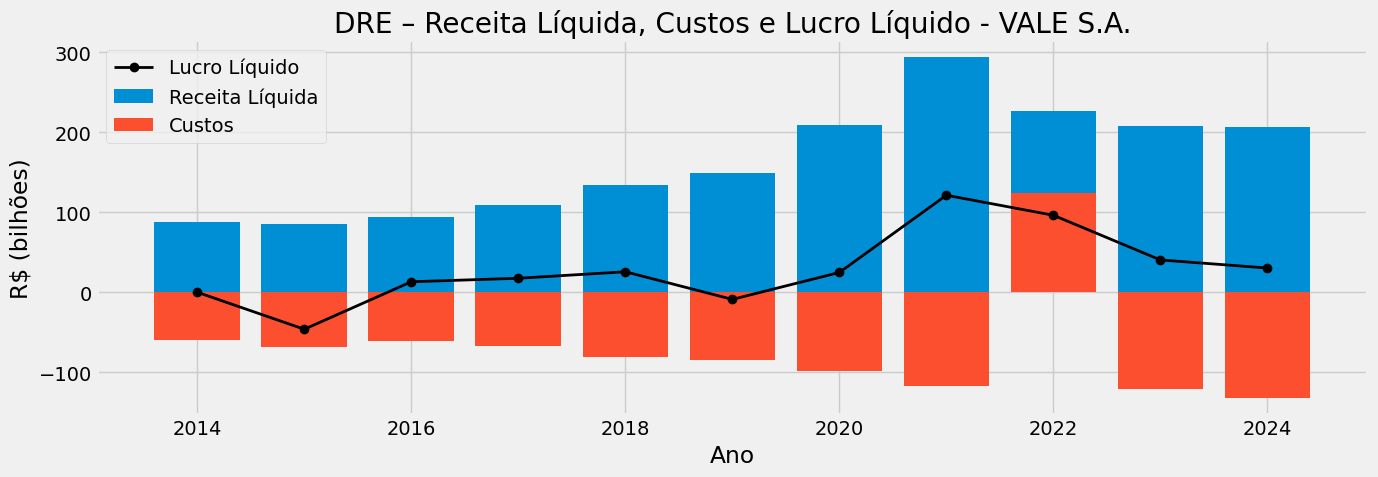

In [127]:

anos = rl_pivot.index

plt.figure(figsize=(14, 5))

plt.bar(anos, rl_pivot["Receita Líquida"], label="Receita Líquida")
plt.bar(anos, rl_pivot["Custos"], label="Custos")

plt.plot(
    anos,
    rl_pivot["Lucro Líquido"],
    marker="o",
    color="black",
    linewidth=2,
    label="Lucro Líquido"
)

plt.xlabel("Ano")
plt.ylabel("R$ (bilhões)")
plt.legend()
plt.title(f"DRE – Receita Líquida, Custos e Lucro Líquido - {empresa}")

plt.tight_layout()
plt.show()


# Lucro por ação - LPA

taxonomia da CVM
```
3.99        Lucro por Ação
├── 3.99.01 Lucro Básico por Ação
│   ├── 3.99.01.01 ON
│   └── 3.99.01.02 PN
└── 3.99.02 Lucro Diluído por Ação
    ├── 3.99.02.01 ON
    └── 3.99.02.02 PN

```
| Para análise                        | Conta                               |
| ----------------------------------- | ----------------------------------- |
| EPS básico (fundamentalista padrão) | **3.99.01** ou **3.99.01.01 / .02** |
| EPS diluído (análise conservadora)  | 3.99.02                             |


3.99.01 é o valor médio ponderado do LPA básico, considerando todas as classes de ações juntas.
A CVM permite que empresas divulguem apenas 3.99.01 (sem separar classes), ou 3.99.01.01 e 3.99.01.02 separadamente. o Lucro Diluído por Ação (3.99.02) considera a possível diluição futura por: Opções de ações; Debêntures conversíveis; Stock options; Warrants. É mais conservador, mas nem sempre relevante no Brasil, porque muitas empresas têm pouca diluição potencial.

In [128]:
contas_lpa = {
    "3.99.01.01": "LPA - PN",
    "3.99.01.02": "LPA - ON"
}

# contas_lpa2 = {
#     "3.99.02.01": "LPA - ON",
#     "3.99.02.02": "LPA - PN"
# }

lpa  = dre_empresa[dre_empresa["CD_CONTA"].isin(contas_lpa.keys()) 
            #   &  dre_empresa["CD_CONTA"].isin(contas_lpa2.keys()) 
             ].copy()
lpa["Conta"] = lpa["CD_CONTA"].map(contas_lpa)

lpa_pivot = lpa.pivot_table(
    index='ano', 
    columns='Conta', 
    values='VL_CONTA', 
    aggfunc='mean'  # Usamos mean para evitar duplicatas caso existam
).sort_index()        
lpa

,CNPJ_CIA,DT_REFER,VERSAO,DT_INI_EXERC,DT_FIM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA,ST_CONTA_FIXA,ano,Conta
90501,33.592.510/0001-54,2017-12-31,1,2017-01-01,2017-12-31,3.99.01.01,PNA,3390.0,N,2017,LPA - PN
90503,33.592.510/0001-54,2017-12-31,1,2017-01-01,2017-12-31,3.99.01.02,ON,3390.0,N,2017,LPA - ON
271038,33.592.510/0001-54,2023-12-31,1,2023-01-01,2023-12-31,3.99.01.01,PNA,0.0,N,2023,LPA - PN
271040,33.592.510/0001-54,2023-12-31,1,2023-01-01,2023-12-31,3.99.01.02,ON,9150.0,N,2023,LPA - ON
204494,33.592.510/0001-54,2021-12-31,1,2021-01-01,2021-12-31,3.99.01.01,PNA,0.0,N,2021,LPA - PN
204496,33.592.510/0001-54,2021-12-31,1,2021-01-01,2021-12-31,3.99.01.02,ON,24180.0,N,2021,LPA - ON
172694,33.592.510/0001-54,2020-12-31,1,2020-01-01,2020-12-31,3.99.01.01,PNA,0.0,N,2020,LPA - PN
172696,33.592.510/0001-54,2020-12-31,1,2020-01-01,2020-12-31,3.99.01.02,ON,5210.0,N,2020,LPA - ON
16040,33.592.510/0001-54,2014-12-31,1,2014-01-01,2014-12-31,3.99.01.02,ON,185.2,N,2014,LPA - ON
16038,33.592.510/0001-54,2014-12-31,1,2014-01-01,2014-12-31,3.99.01.01,PNA,185.2,N,2014,LPA - PN


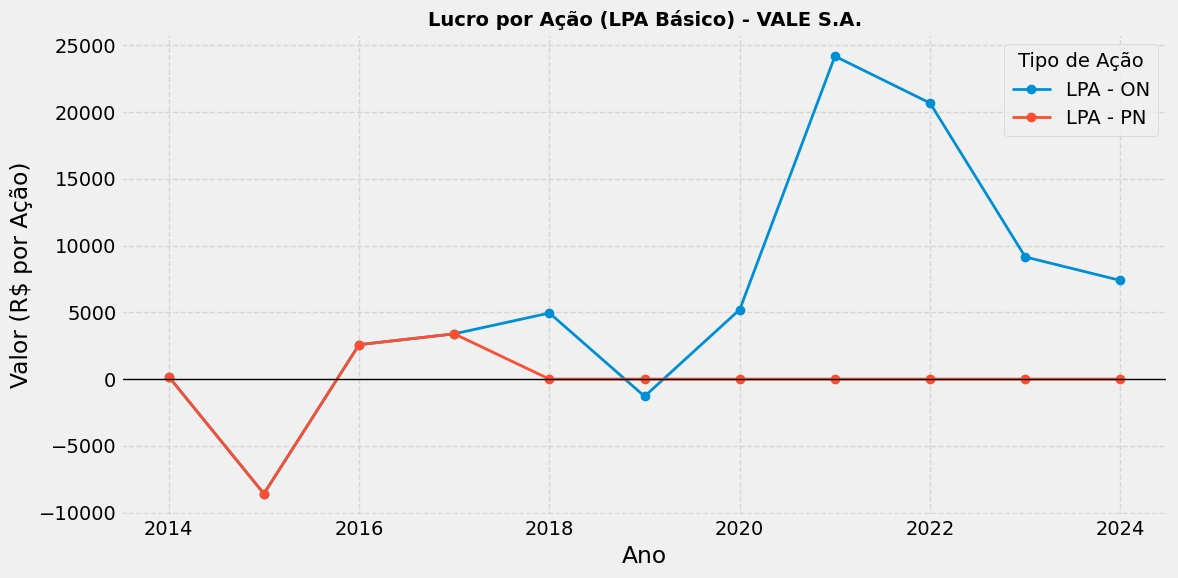

In [129]:
if not lpa_pivot.empty:
    plt.figure(figsize=(12, 6))
    
    # Plotar uma linha para cada tipo de ação encontrada (ON, PN, PNA, etc)
    for coluna in lpa_pivot.columns:
        plt.plot(lpa_pivot.index, lpa_pivot[coluna], marker='o', label=coluna, linewidth=2)

    plt.title(f"Lucro por Ação (LPA Básico) - {empresa}", fontsize=14, fontweight='bold')
    plt.xlabel("Ano")
    plt.ylabel("Valor (R$ por Ação)")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title="Tipo de Ação")
    
    # Adicionar linha de referência no zero
    plt.axhline(0, color='black', linewidth=1, linestyle='-')
    
    plt.tight_layout()
    plt.savefig('lpa_por_acao.png') # Salva a imagem para visualização
    plt.show()
else:
    print("Dados de LPA não encontrados para as contas 3.99.01.01 ou 3.99.01.02 desta empresa.")

# Margens

### EBITDA

### DVA

In [130]:
dva = extract_report(start_year=ano_inicio, end_year=ano_fim, report='DVA_con').copy()

✓ Processado: dfp_cia_aberta_2014.zip (29585 registros)
✓ Processado: dfp_cia_aberta_2015.zip (29330 registros)
✓ Processado: dfp_cia_aberta_2016.zip (29318 registros)
✓ Processado: dfp_cia_aberta_2017.zip (29390 registros)
✓ Processado: dfp_cia_aberta_2018.zip (29464 registros)
✓ Processado: dfp_cia_aberta_2019.zip (33085 registros)
✓ Processado: dfp_cia_aberta_2020.zip (38196 registros)
✓ Processado: dfp_cia_aberta_2021.zip (40230 registros)
✓ Processado: dfp_cia_aberta_2022.zip (42104 registros)
✓ Processado: dfp_cia_aberta_2023.zip (42369 registros)
✓ Processado: dfp_cia_aberta_2024.zip (40022 registros)

✓ Total de arquivos processados: 11


In [131]:
dva['VL_CONTA'] = dva['VL_CONTA'].astype(float)
print(f"{dva['VL_CONTA'].isna().sum()} erros de conversão de numeros")
## strings
dva[['DENOM_CIA','CNPJ_CIA','CD_CONTA']] = dva[['DENOM_CIA','CNPJ_CIA','CD_CONTA']].astype('string')
dva[['ESCALA_MOEDA','DS_CONTA','GRUPO_DFP','MOEDA','ST_CONTA_FIXA']] = dva[['ESCALA_MOEDA','DS_CONTA','GRUPO_DFP','MOEDA','ST_CONTA_FIXA']].astype('category')

dva['DT_REFER'] = pd.to_datetime(dva['DT_REFER']) 
dva['DT_INI_EXERC'] = pd.to_datetime(dva['DT_INI_EXERC'])
dva['DT_FIM_EXERC'] = pd.to_datetime(dva['DT_FIM_EXERC'])

# Normalização de Escala 
print('Escalas da moeda: ',dva.ESCALA_MOEDA.unique().tolist(),end=' --- ')
if len(dva.ESCALA_MOEDA.unique().tolist()) > 2: print('VERIFICAR ESCALAS DE MOEDA!!!') 
else: print('Escalas OK')
dva['VL_CONTA'] = dva.apply(lambda row: row['VL_CONTA'] * 1000 if row['ESCALA_MOEDA'] == 'MIL' else row['VL_CONTA'], axis=1)
dva.head(1)

0 erros de conversão de numeros
Escalas da moeda:  ['MIL', 'UNIDADE'] --- Escalas OK


,CNPJ_CIA,DT_REFER,VERSAO,DENOM_CIA,CD_CVM,GRUPO_DFP,MOEDA,ESCALA_MOEDA,ORDEM_EXERC,DT_INI_EXERC,DT_FIM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA,ST_CONTA_FIXA
0,00.000.000/0001-91,2014-12-31,2,BCO BRASIL S.A.,1023,DF Consolidado - Demonstração de Valor Adicionado,REAL,MIL,PENÚLTIMO,2013-01-01,2013-12-31,7.01,Receitas,1.147987e+11,S


In [143]:
# remover_cols = ['GRUPO_DFP','MOEDA','ORDEM_EXERC','DENOM_CIA','CD_CVM','ESCALA_MOEDA'] # mesmas do dre

dva_empresa = dva[(dva['CD_CVM'] == cod_cvm) & (dva['ORDEM_EXERC'] == 'ÚLTIMO')].copy().drop(remover_cols, axis=1)
dva_empresa['ano'] = dva_empresa['DT_REFER'].dt.year
dva_empresa = dva_empresa.sort_values('VERSAO').drop_duplicates(subset=['DT_REFER', 'CD_CONTA'], keep='last')

dva_empresa.head(2)

,CNPJ_CIA,DT_REFER,VERSAO,DT_INI_EXERC,DT_FIM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA,ST_CONTA_FIXA,ano
18714,33.592.510/0001-54,2014-12-31,1,2014-01-01,2014-12-31,7.01,Receitas,1.187632e+11,S,2014
327251,33.592.510/0001-54,2023-12-31,1,2023-01-01,2023-12-31,7.02.01,"Custos Prods., Mercs. e Servs. Vendidos",-4.257800e+10,S,2023


Depreciação e Amortização

In [144]:
contas_encontradas = dva[ (dva['DENOM_CIA']==empresa) & (dva['DS_CONTA'].str.contains('Deprecia', case=False, na=False))].sort_values('CD_CONTA')[['CD_CONTA','DS_CONTA']]
if not contas_encontradas.empty:
    codigo_deprec_dinamico = contas_encontradas.iloc[0]['CD_CONTA']
    nome_conta_deprec = contas_encontradas.iloc[0]['DS_CONTA']
    print(f"Conta identificada: {codigo_deprec_dinamico} - {nome_conta_deprec}")
else:
    print("Conta de depreciação não encontrada para esta empresa.")

Conta identificada: 7.04.01 - Depreciação, Amortização e Exaustão


Diferença entre as Contas de depreciação

7.04.01 - Depreciação, Amortização e Exaustão: Esta conta refere-se à depreciação própria da companhia. Ela registra a perda de valor dos ativos que pertencem à empresa e que foram utilizados no processo de produção de bens ou serviços durante o período. No esquema da DVA, ela é considerada uma "Retenção" (riqueza que a empresa retém para repor seu capital físico).

7.05.01 - Depreciação, Amortização e Exaustão (dentro de Valor Adicionado Recebido em Transferência): Esta conta aparece no grupo de "Valor Adicionado Recebido em Transferência". Ela geralmente se refere à parcela de depreciação que foi "repassada" para a empresa por meio de participações em outras entidades (como Equivalência Patrimonial em controladas ou coligadas) ou outras transferências. Ou seja, é a depreciação que ocorreu em uma investida e que impacta o resultado que chega até a empresa principal.

Para o cálculo do EBITDA a lógica é reverter os efeitos "não caixa" do resultado operacional, a  regra geral é somar ao Lucro Operacional (EBIT) a Depreciação Total que transitou pelo Resultado do Exercício. Na prática a maioria das análises de mercado  utiliza a depreciação relativa à operação direta da empresa (7.04.01). *O cuidado com a 7.05.01*: Se o objetivo é calcular o EBITDA da holding incluindo o desempenho operacional das controladas capturado via equivalência, alguns analistas podem considerar ambas. No entanto, o padrão contábil do EBITDA foca no operacional direto.

In [145]:
dre_dva = pd.concat([
    dva_empresa[dva_empresa['CD_CONTA'] == codigo_deprec_dinamico],
    dre_empresa], 
    ignore_index=True)
dre_dva.reset_index(drop=True, inplace=True)

dre_dva.head(1)

,CNPJ_CIA,DT_REFER,VERSAO,DT_INI_EXERC,DT_FIM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA,ST_CONTA_FIXA,ano
0,33.592.510/0001-54,2023-12-31,1,2023-01-01,2023-12-31,7.04.01,"Depreciação, Amortização e Exaustão",-1.530000e+10,S,2023


In [146]:
contas_margens = {
    "3.01": "Receita Líquida",
    "3.03": "Lucro Bruto",
    "3.05": "EBIT",
    "3.11": "Lucro Líquido",
    "7.04.01" : "D&A", 
    "7.05.01" : "D&A"
}

margens = dre_dva[dre_dva["CD_CONTA"].isin(contas_margens.keys()) 
                  & (dre_dva["ST_CONTA_FIXA"] == 'S')
                  ].copy()
margens["Conta"] = margens["CD_CONTA"].map(contas_margens)

# Pivotar os dados por ano
margens_pivot = margens.pivot_table(
    index="ano",
    columns="Conta",
    values="VL_CONTA",
    aggfunc="sum"
).sort_index()



margens_pivot["EBITDA"] = margens_pivot["EBIT"] + margens_pivot["D&A"]

# Cálculo das Margens em porcentagem (%)
margens_pivot["Margem Bruta (%)"] = (margens_pivot["Lucro Bruto"] / margens_pivot["Receita Líquida"]) * 100
margens_pivot["Margem EBIT (%)"] = (margens_pivot["EBIT"] / margens_pivot["Receita Líquida"]) * 100
margens_pivot["Margem Líquida (%)"] = (margens_pivot["Lucro Líquido"] / margens_pivot["Receita Líquida"]) * 100
margens_pivot["Margem EBITDA (%)"] = (margens_pivot["EBITDA"] / margens_pivot["Receita Líquida"]) * 100


margens_pivot



Conta,D&A,EBIT,Lucro Bruto,Lucro Líquido,Receita Líquida,EBITDA,Margem Bruta (%),Margem EBIT (%),Margem Líquida (%),Margem EBITDA (%)
ano,,,,,,,,,,
2014,-1.010946e+10,1.757260e+10,2.918866e+10,2.195880e+08,8.827456e+10,7.463143e+09,33.065765,19.906751,0.248756,8.454466
2015,-1.348901e+10,-2.833714e+10,1.684145e+10,-4.599662e+10,8.549918e+10,-4.182615e+10,19.697790,-33.143169,-53.797732,-48.919941
2016,-1.210686e+10,2.507273e+10,3.348983e+10,1.329650e+10,9.463326e+10,1.296587e+10,35.389072,26.494631,14.050552,13.701178
2017,-1.184236e+10,3.453368e+10,4.127471e+10,1.766999e+10,1.085320e+11,2.269132e+10,38.029984,31.818884,16.280902,20.907488
2018,-1.223894e+10,4.317574e+10,5.328222e+10,2.577377e+10,1.344831e+11,3.093681e+10,39.620006,32.104953,19.165057,23.004231
2019,-1.475073e+10,2.239775e+09,6.480436e+10,-8.696040e+09,1.486399e+11,-1.251096e+10,43.598219,1.506846,-5.850407,-8.416957
2020,-1.667922e+10,5.206762e+10,1.099613e+11,2.490234e+10,2.085288e+11,3.538840e+10,52.731942,24.969035,11.941922,16.970514
2021,-1.637900e+10,1.413350e+11,1.762570e+11,1.213430e+11,2.935240e+11,1.249560e+11,60.048582,48.151088,41.340061,42.570965
2022,-1.638600e+10,9.032600e+10,1.023130e+11,9.633700e+10,2.265080e+11,7.394000e+10,45.169707,39.877620,42.531390,32.643439


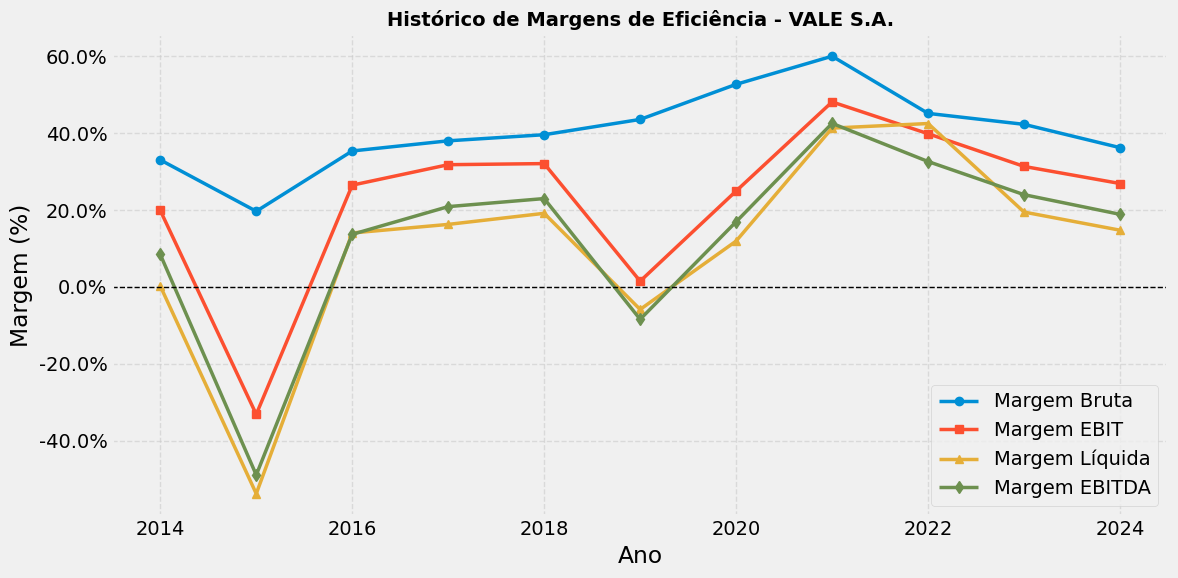

In [147]:

plt.figure(figsize=(12, 6))
plt.plot(margens_pivot.index, margens_pivot["Margem Bruta (%)"], marker='o', label="Margem Bruta", linewidth=2.5)
plt.plot(margens_pivot.index, margens_pivot["Margem EBIT (%)"], marker='s', label="Margem EBIT", linewidth=2.5)
plt.plot(margens_pivot.index, margens_pivot["Margem Líquida (%)"], marker='^', label="Margem Líquida", linewidth=2.5)
plt.plot(margens_pivot.index, margens_pivot["Margem EBITDA (%)"], marker='d', label="Margem EBITDA", linewidth=2.5)

plt.title(f"Histórico de Margens de Eficiência - {empresa}", fontsize=14, fontweight='bold')
plt.xlabel("Ano")
plt.ylabel("Margem (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.axhline(0, color='black', linestyle='--', linewidth=1) # Linha de referência no zero

# Formatação do eixo Y para mostrar o símbolo de %
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f%%'))

plt.tight_layout()
plt.show()

# P/L

In [ ]:

import re
from difflib import SequenceMatcher

def limpar_nome_empresa(nome):
    """Remove sufixos comuns e normaliza o nome da empresa"""
    nome = nome.upper().strip()
    # Remove sufixos comuns
    sufixos = [' S.A.', ' S/A', ' SA', ' LTDA', ' LTDA.', ' S.A', 
               ' CIA', ' COMPANHIA', ' HOLDING']
    for sufixo in sufixos:
        nome = nome.replace(sufixo, '')
    return nome.strip()

def buscar_ticker_yahoo(nome_empresa):
    """
    Busca possíveis tickers no Yahoo Finance para uma empresa brasileira
    """
    nome_limpo = limpar_nome_empresa(nome_empresa)
    
    # Tenta buscar usando yfinance
    try:
        # Monta query de busca
        ticker_obj = yf.Ticker(f"{nome_limpo}.SA")
        info = ticker_obj.info
        
        if info and 'symbol' in info:
            return [info['symbol']]
    except:
        pass
    
    return []

def buscar_tickers_b3(nome_empresa):
    """
    Método alternativo: usa lista conhecida de empresas da B3
    Você pode expandir essa lista ou carregar de um arquivo CSV
    """
    # Dicionário com mapeamento manual (exemplos)
    mapeamento_conhecido = {
        'VALE': ['VALE3.SA'],
        'PETROBRAS': ['PETR3.SA', 'PETR4.SA'],
        'ITAU': ['ITUB3.SA', 'ITUB4.SA'],
        'BRADESCO': ['BBDC3.SA', 'BBDC4.SA'],
        'BANCO DO BRASIL': ['BBAS3.SA'],
        'AMBEV': ['ABEV3.SA'],
        'MAGAZINE LUIZA': ['MGLU3.SA'],
        'B3': ['B3SA3.SA'],
        'WEG': ['WEGE3.SA'],
        'SUZANO': ['SUZB3.SA'],
    }
    
    nome_limpo = limpar_nome_empresa(nome_empresa)
    
    for chave, tickers in mapeamento_conhecido.items():
        if chave in nome_limpo or nome_limpo in chave:
            return tickers
    
    return []

def similaridade(a, b):
    """Calcula similaridade entre duas strings"""
    return SequenceMatcher(None, a.upper(), b.upper()).ratio()

def buscar_ticker_completo(nome_empresa, threshold=0.6):
    """
    Busca mais completa combinando diferentes métodos
    """
    print(f"\nBuscando tickers para: {nome_empresa}")
    
    resultados = []
    
    # Método 1: Busca em mapeamento conhecido
    tickers_b3 = buscar_tickers_b3(nome_empresa)
    if tickers_b3:
        print(f"  ✓ Encontrado em mapeamento: {tickers_b3}")
        resultados.extend(tickers_b3)
    
    # Método 2: Busca direta no Yahoo
    tickers_yahoo = buscar_ticker_yahoo(nome_empresa)
    if tickers_yahoo:
        print(f"  ✓ Encontrado no Yahoo: {tickers_yahoo}")
        resultados.extend(tickers_yahoo)
    
    # Remove duplicatas
    resultados = list(set(resultados))
    
    if not resultados:
        print(f"  ✗ Nenhum ticker encontrado")
        return None
    
    # Valida se os tickers existem no Yahoo Finance
    tickers_validos = []
    for ticker in resultados:
        try:
            dados = yf.Ticker(ticker)
            info = dados.info
            if info and 'symbol' in info:
                tickers_validos.append(ticker)
                print(f"  ✓ Ticker validado: {ticker}")
        except:
            print(f"  ✗ Ticker inválido: {ticker}")
    
    return tickers_validos if tickers_validos else None


In [283]:
buscar_ticker_completo(empresa)


Buscando tickers para: VALE S.A.
  ✓ Encontrado em mapeamento: ['VALE3.SA']


HTTP Error 404: 


  ✓ Ticker validado: VALE3.SA


['VALE3.SA']

In [ ]:
import unidecode
from rapidfuzz import process, fuzz
import re

df_b3 = pd.read_csv(
    "/home/yair/GHub/Finance-playground/data/acoes-listadas-b3.csv",
    usecols=["Ticker","Nome"]
)

def normalizar(nome):
    nome = unidecode.unidecode(nome.upper())
    nome = re.sub(r'[^A-Z0-9 ]',' ', nome)
    nome = re.sub(r'\s+',' ', nome).strip()
    return nome

def cvm_para_ticker(nome_cvm):
    nome_norm = normalizar(nome_cvm)
    
    match, score, idx = process.extractOne(
        nome_norm,
        lista_nomes,
        scorer=fuzz.token_sort_ratio
    )
    if score >= 80:
        return df_b3.iloc[idx]["Ticker"]
    return None


lista_nomes = (df_b3["Nome"].apply(normalizar)).tolist()


In [280]:
cvm_para_ticker(empresa)

In [281]:
cvm_para_ticker(normalizar("VALE S.A"))


In [227]:
def criar_calendario_anbima():
    '''
    retorna uma instancia do objeto Calendar contendo os feriados nacionais obtidos no site da Anbima.
    '''
    from bizdays import Calendar

    # Extrai a lista de feriados direto do site da anbima
    holidays = pd.read_excel('http://www.anbima.com.br/feriados/arqs/feriados_nacionais.xls', skipfooter=9)["Data"]
    weekends = ["Saturday", "Sunday"]
    # Cria o calendário
    calendar = Calendar(holidays, weekends)
    return calendar

def previous_business_day(cal, data):
    d = data.date() 
    return d if cal.isbizday(d) else cal.preceding(d)
  
def ultimo_pregao_disponivel(data, precos_index):
    """
    Retorna a maior data no índice de preços que seja <= data.
    """
    datas_validas = precos_index[precos_index <= pd.Timestamp(data)]
    if datas_validas.empty:
        return None
    return datas_validas.max()



In [246]:
import yfinance as yf

cal = criar_calendario_anbima()

inicio = dre_dva.DT_FIM_EXERC.unique().min()
fim = dre_dva.DT_FIM_EXERC.unique().max()
# ultimo dia util <=  data dada
inicio_util = cal.offset(previous_business_day(cal , inicio) , -3 )
fim_util    = cal.offset(previous_business_day(cal , fim), +3 )

precos =  yf.download(
    "VALE3.SA",
    start=inicio_util,
    end=fim_util + pd.Timedelta(days=1),  # end no yfinance é exclusivo
    interval="1d",
    progress=False, auto_adjust=True
)#[['Close']]
precos.columns = precos.columns.droplevel(1)

# Dia útil contábil
lpa_on['DT_UTIL'] = lpa_on['DT_FIM_EXERC'].apply(
    lambda d: previous_business_day(cal, d))
# Último pregão disponível na base de preços
lpa_on['DT_PRECO'] = lpa_on['DT_UTIL'].apply(
    lambda d: ultimo_pregao_disponivel(d, precos.index)
)


In [250]:
df_pl = lpa_on.merge(
    precos,
    left_on='DT_PRECO',
    right_index=True,
    how='left'
)

df_pl['LPA_R$'] = df_pl['VL_CONTA'] / 1000
df_pl['P_L'] = df_pl['Close'] / df_pl['LPA_R$']
df_pl = df_pl[['ano','DT_FIM_EXERC','DT_PRECO','LPA_R$','Close','P_L']]
df_pl = df_pl.sort_values('ano').reset_index(drop=True)

df_pl

,ano,DT_FIM_EXERC,DT_PRECO,LPA_R$,Close,P_L
0,2014,2014-12-31,2014-12-30,0.1852,10.278435,55.499108
1,2015,2015-12-31,2015-12-30,-8.5800,6.442202,-0.750839
2,2016,2016-12-31,2016-12-29,2.5800,12.771125,4.950048
3,2017,2017-12-31,2017-12-29,3.3900,20.910994,6.168435
4,2018,2018-12-31,2018-12-28,4.9500,27.562450,5.568172
5,2019,2019-12-31,2019-12-30,-1.2900,29.568762,-22.921521
6,2020,2020-12-31,2020-12-30,5.2100,50.541843,9.700930
7,2021,2021-12-31,2021-12-30,24.1800,53.004623,2.192085
8,2022,2022-12-31,2022-12-29,20.6700,66.229446,3.204134
9,2023,2023-12-31,2023-12-28,9.1500,62.431614,6.823127


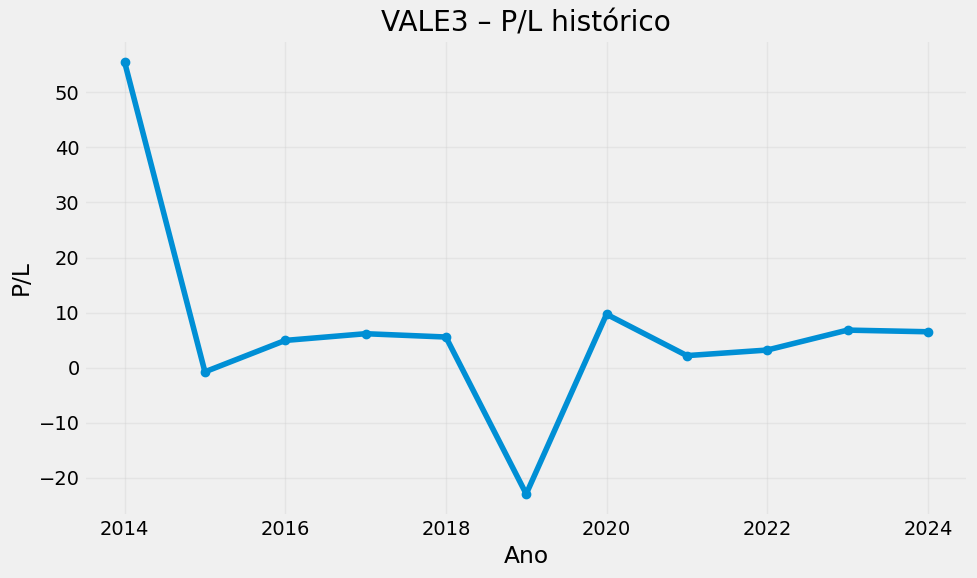

In [251]:
plt.figure(figsize=(10,6))

plt.plot(df_pl['ano'], df_pl['P_L'], marker='o')

plt.title("VALE3 – P/L histórico")
plt.xlabel("Ano")
plt.ylabel("P/L")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Dividendos

In [ ]:
dva[dva['DS_CONTA'].str.contains('Juros sobre o Capital Próprio', case=False, na=False)]

,CNPJ_CIA,DT_REFER,VERSAO,DENOM_CIA,CD_CVM,GRUPO_DFP,MOEDA,ESCALA_MOEDA,ORDEM_EXERC,DT_INI_EXERC,DT_FIM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA,ST_CONTA_FIXA
80,00.000.000/0001-91,2014-12-31,2,BCO BRASIL S.A.,1023,DF Consolidado - Demonstração de Valor Adicionado,REAL,MIL,PENÚLTIMO,2013-01-01,2013-12-31,7.09.04.01,Juros sobre o Capital Próprio,3.313923e+09,S
81,00.000.000/0001-91,2014-12-31,2,BCO BRASIL S.A.,1023,DF Consolidado - Demonstração de Valor Adicionado,REAL,MIL,ÚLTIMO,2014-01-01,2014-12-31,7.09.04.01,Juros sobre o Capital Próprio,3.674036e+09,S
158,00.000.208/0001-00,2014-12-31,2,BRB BANCO DE BRASILIA S.A.,14206,DF Consolidado - Demonstração de Valor Adicionado,REAL,MIL,PENÚLTIMO,2013-01-01,2013-12-31,7.09.04.01,Juros sobre o Capital Próprio,3.550500e+07,S
159,00.000.208/0001-00,2014-12-31,2,BRB BANCO DE BRASILIA S.A.,14206,DF Consolidado - Demonstração de Valor Adicionado,REAL,MIL,ÚLTIMO,2014-01-01,2014-12-31,7.09.04.01,Juros sobre o Capital Próprio,3.996600e+07,S
254,00.001.180/0001-26,2014-12-31,2,CENTRAIS ELET BRAS S.A. - ELETROBRAS,2437,DF Consolidado - Demonstração de Valor Adicionado,REAL,MIL,PENÚLTIMO,2013-01-01,2013-12-31,7.08.04.01,Juros sobre o Capital Próprio,4.339620e+08,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382916,96.418.264/0218-02,2024-12-31,1,LOJAS QUERO QUERO S.A.,25038,DF Consolidado - Demonstração de Valor Adicionado,REAL,MIL,ÚLTIMO,2024-01-01,2024-12-31,7.08.04.01,Juros sobre o Capital Próprio,2.380700e+07,S
382995,97.191.902/0001-94,2024-12-31,1,CONSERVAS ODERICH S.A.,4693,DF Consolidado - Demonstração de Valor Adicionado,REAL,MIL,PENÚLTIMO,2023-01-01,2023-12-31,7.08.04.01,Juros sobre o Capital Próprio,2.844400e+07,S
382996,97.191.902/0001-94,2024-12-31,1,CONSERVAS ODERICH S.A.,4693,DF Consolidado - Demonstração de Valor Adicionado,REAL,MIL,ÚLTIMO,2024-01-01,2024-12-31,7.08.04.01,Juros sobre o Capital Próprio,1.100500e+07,S
383083,97.837.181/0001-47,2024-12-31,1,DEXCO S.A.,21091,DF Consolidado - Demonstração de Valor Adicionado,REAL,MIL,PENÚLTIMO,2023-01-01,2023-12-31,7.08.04.01,Juros sobre o Capital Próprio,2.316920e+08,S


: 

: 

: 

In [ ]:
dva[(dva['DS_CONTA'].str.contains('Dividendos', case=False, na=False)) &(dva['ORDEM_EXERC']=='ÚLTIMO')]

,CNPJ_CIA,DT_REFER,VERSAO,DENOM_CIA,CD_CVM,GRUPO_DFP,MOEDA,ESCALA_MOEDA,ORDEM_EXERC,DT_INI_EXERC,DT_FIM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA,ST_CONTA_FIXA
83,00.000.000/0001-91,2014-12-31,2,BCO BRASIL S.A.,1023,DF Consolidado - Demonstração de Valor Adicionado,REAL,MIL,ÚLTIMO,2014-01-01,2014-12-31,7.09.04.02,Dividendos,851104000.0,S
161,00.000.208/0001-00,2014-12-31,2,BRB BANCO DE BRASILIA S.A.,14206,DF Consolidado - Demonstração de Valor Adicionado,REAL,MIL,ÚLTIMO,2014-01-01,2014-12-31,7.09.04.02,Dividendos,3460000.0,S
257,00.001.180/0001-26,2014-12-31,2,CENTRAIS ELET BRAS S.A. - ELETROBRAS,2437,DF Consolidado - Demonstração de Valor Adicionado,REAL,MIL,ÚLTIMO,2014-01-01,2014-12-31,7.08.04.02,Dividendos,0.0,S
307,00.070.698/0001-11,2014-12-31,1,COMPANHIA ENERGÉTICA DE BRASÍLIA - CEB,14451,DF Consolidado - Demonstração de Valor Adicionado,REAL,MIL,ÚLTIMO,2014-01-01,2014-12-31,7.06.03.01,Dividendos Recebidos,717000.0,N
347,00.070.698/0001-11,2014-12-31,1,COMPANHIA ENERGÉTICA DE BRASÍLIA - CEB,14451,DF Consolidado - Demonstração de Valor Adicionado,REAL,MIL,ÚLTIMO,2014-01-01,2014-12-31,7.08.04.02,Dividendos,0.0,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382750,94.813.102/0001-70,2024-12-31,2,TRÊS TENTOS AGROINDUSTRIAL S/A,25950,DF Consolidado - Demonstração de Valor Adicionado,REAL,MIL,ÚLTIMO,2024-01-01,2024-12-31,7.08.04.02,Dividendos,58411000.0,S
382838,96.298.013/0001-68,2024-12-31,2,PACAEMBU CONSTRUTORA S.A.,25143,DF Consolidado - Demonstração de Valor Adicionado,REAL,MIL,ÚLTIMO,2024-01-01,2024-12-31,7.08.04.02,Dividendos,0.0,S
382918,96.418.264/0218-02,2024-12-31,1,LOJAS QUERO QUERO S.A.,25038,DF Consolidado - Demonstração de Valor Adicionado,REAL,MIL,ÚLTIMO,2024-01-01,2024-12-31,7.08.04.02,Dividendos,0.0,S
382998,97.191.902/0001-94,2024-12-31,1,CONSERVAS ODERICH S.A.,4693,DF Consolidado - Demonstração de Valor Adicionado,REAL,MIL,ÚLTIMO,2024-01-01,2024-12-31,7.08.04.02,Dividendos,0.0,S


: 

: 

: 

In [ ]:
dva[dva['CD_CONTA']=='7.08'].DS_CONTA.iloc[0]

'Valor Adicionado Total a Distribuir'

: 

: 

: 

In [ ]:
dva[dva['CD_CONTA']=='7.09'].DS_CONTA.iloc[0]

'Distribuição do Valor Adicionado'

: 

: 

: 

In [ ]:
# Definir mapeamento de contas (considerando variações de códigos CVM para Bancos e Não-Bancos)
# As contas de distribuição de capital próprio na DVA costumam ser 7.08.04 ou 7.09.04
contas_payout = {
    "7.08.04.01": "JCP",
    "7.08.04.02": "Dividendos",
    "7.09.04.01": "JCP",
    "7.09.04.02": "Dividendos"
}

payout = dva[
    (dva['CD_CVM'] == cod_cvm) & 
    (dva['CD_CONTA'].isin(contas_payout.keys())) & 
    (dva['ORDEM_EXERC'] == 'ÚLTIMO')].copy()

payout['Provento'] = payout['CD_CONTA'].map(contas_payout)

# Pivotar para ter anos no índice e Proventos como colunas
payout_pivot = payout.pivot_table(
    index="ano", 
    columns="Provento", 
    values="VL_CONTA", 
    aggfunc="sum"
).fillna(0)

# Garantir que ambas as colunas existam para evitar erro no gráfico
for col in ["Dividendos", "JCP"]:
    if col not in payout_pivot.columns:
        payout_pivot[col] = 0

# 4. Gerar o Gráfico de Barras Empilhadas
plt.figure(figsize=(12, 6))

# Barras de JCP (Base) - Azul
plt.bar(payout_pivot.index, payout_pivot["JCP"], color='#0077b6', label='Juros sobre Capital Próprio (JCP)')

# Barras de Dividendos (Topo) - Verde
plt.bar(payout_pivot.index, payout_pivot["Dividendos"], bottom=payout_pivot["JCP"], color='#2a9d8f', label='Dividendos')

plt.title(f"Distribuição de Proventos Anuais - {empresa}", fontsize=14, fontweight='bold')
plt.ylabel("Valor (em Milhares de Reais)")
plt.xlabel("Ano")
plt.xticks(payout_pivot.index)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

KeyError: 'ano'

: 

: 

: 

DRE

In [ ]:
filtro = ['3.01', #Receita de Venda de Bens e/ou Serviços
          '3.02', #Custo dos Bens e/ou Serviços Vendidos
          '3.03', #Resultado Bruto
          '3.04', #Despesas/Receitas Operacionais
          '3.05', #Resultado Antes do Resultado Financeiro e dos Tributos
          '3.06', #Resultado Financeiro
          '3.07', #Resultado Antes dos Tributos sobre o Lucro
          '3.08', #Imposto de Renda e Contribuição Social sobre o Lucro
          '3.09', # Resultado Líquido das Operações Continuadas
          '3.11'  #Lucro/Prejuízo Consolidado do Período
          ]

: 

: 

: 

In [ ]:
nova_dre_empresa = show_table(dre_empresa,filtro)
display(HTML(nova_dre_empresa.reset_index().drop('CD_CONTA', axis = 1).to_html(index=False)))

: 

: 

: 

In [ ]:
from great_tables import GT, md, html, style, loc

anos = [str(ano) for ano in range(ano_inicio, ano_fim + 1)]
outros = list(nova_dre_empresa.columns.difference(anos))

gt = (
    GT(nova_dre_empresa.reset_index().drop('CD_CONTA', axis = 1),
        rowname_col='DS_CONTA')
    .tab_header(title=md(f'**Demonstrações do Resultado de Exercício (DRE)** <br> **{empresa}**'))
    .tab_source_note(source_note=md("**Fonte: CVM**"))
    .fmt_currency(
        columns= anos,
        currency='BRL',
        locale='br'
    )
    .fmt_percent(
        columns= outros,
        scale_values=False,
        dec_mark=',',
        sep_mark='.'
    )
    .opt_all_caps(locations='column_labels')
    # .opt_align(align='center')  # Centralizar todas as colunas, se necessário
)

gt  # Apenas referenciando o objeto, caso ele seja automaticamente renderizável no ambiente


: 

: 

: 